In [1]:
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import matplotlib.patches as patches
sns.set_style('darkgrid')
import pickle
from matplotlib import gridspec
from matplotlib.lines import Line2D
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set_style('darkgrid')

In [3]:
standard = ['Blank', 'Standard 1', 'Standard 2', 'Standard 3', 'Standard 4', 'Standard 5', 'Standard 6']

- calculate hydroxyproline by multiplying the averaged absorbance by the fitted line coefficients. 

In [4]:
def cal_hyd(row, date, max_hydro):
    if (row.Date == date) and (row.Rabbit_ID not in standard):
        hydro_t =  row.a * (row['Absorbance']) + row.b
        if (hydro_t <= max_hydro):
            return hydro_t
        else:
            return np.NAN
    else:
        return row.Hydroxyproline

In [5]:
path = '/Users/trongnguyen/Dropbox/FattyLiver/results/master_hydroproline.xlsx'

In [6]:
xl = pd.ExcelFile(path)

In [7]:
df = xl.parse(sheetname='Sheet1')

 - the date of the experiment


In [8]:
date1 = pd.Timestamp(datetime.datetime(2016, 11, 9)) #'2016-11-09'
date2 = pd.Timestamp(datetime.datetime(2016, 12, 22)) #'2016-12-22'
date3 = pd.Timestamp(datetime.datetime(2017, 11, 21)) #'2017-11-21'
date4 = pd.Timestamp(datetime.datetime(2018, 6, 14)) #'2018-06-14'
date5 = pd.Timestamp(datetime.datetime(2018, 7, 13)) #'2018-07-13'

In [9]:
for date in [date1, date2, date3, date4, date5]:
    experiment = df[df.Date == date]
    temp = experiment[experiment.Rabbit_ID.isin(standard)]
    hydro = temp['Hydroxyproline']
    absorb = temp['Absorbance']
    coeff = np.polyfit(absorb, hydro, 1)
    max_hydro = experiment.Hydroxyproline[experiment.Rabbit_ID == 'Standard 6'].values[0]
    df.loc[df.Date == date,'a'] = coeff[0]
    df.loc[df.Date == date,'b'] = coeff[1]
    df['Hydroxyproline']  = df.apply(lambda row: cal_hyd(row, date, max_hydro), axis =1)

In [10]:
%qtconsole

In [10]:
# remove the standard result
df_remove_standard = df[~df.Rabbit_ID.isin(standard)]

In [11]:
# remove the NaN result
df_remove_negative = df_remove_standard[np.isfinite(df_remove_standard.Hydroxyproline)]

Folch assay result

In [12]:
newdataBase = pd.read_excel('/Users/trongnguyen/Dropbox/FattyLiver/Rabbit_Liver_40.xlsx', sheet_name=0)
dataBase = newdataBase[['Rabbit', 'Injection level', 'Weeks on diet','Lipid']]
dataBase = dataBase[dataBase['Injection level'] >=0]
dataBase = dataBase.dropna()

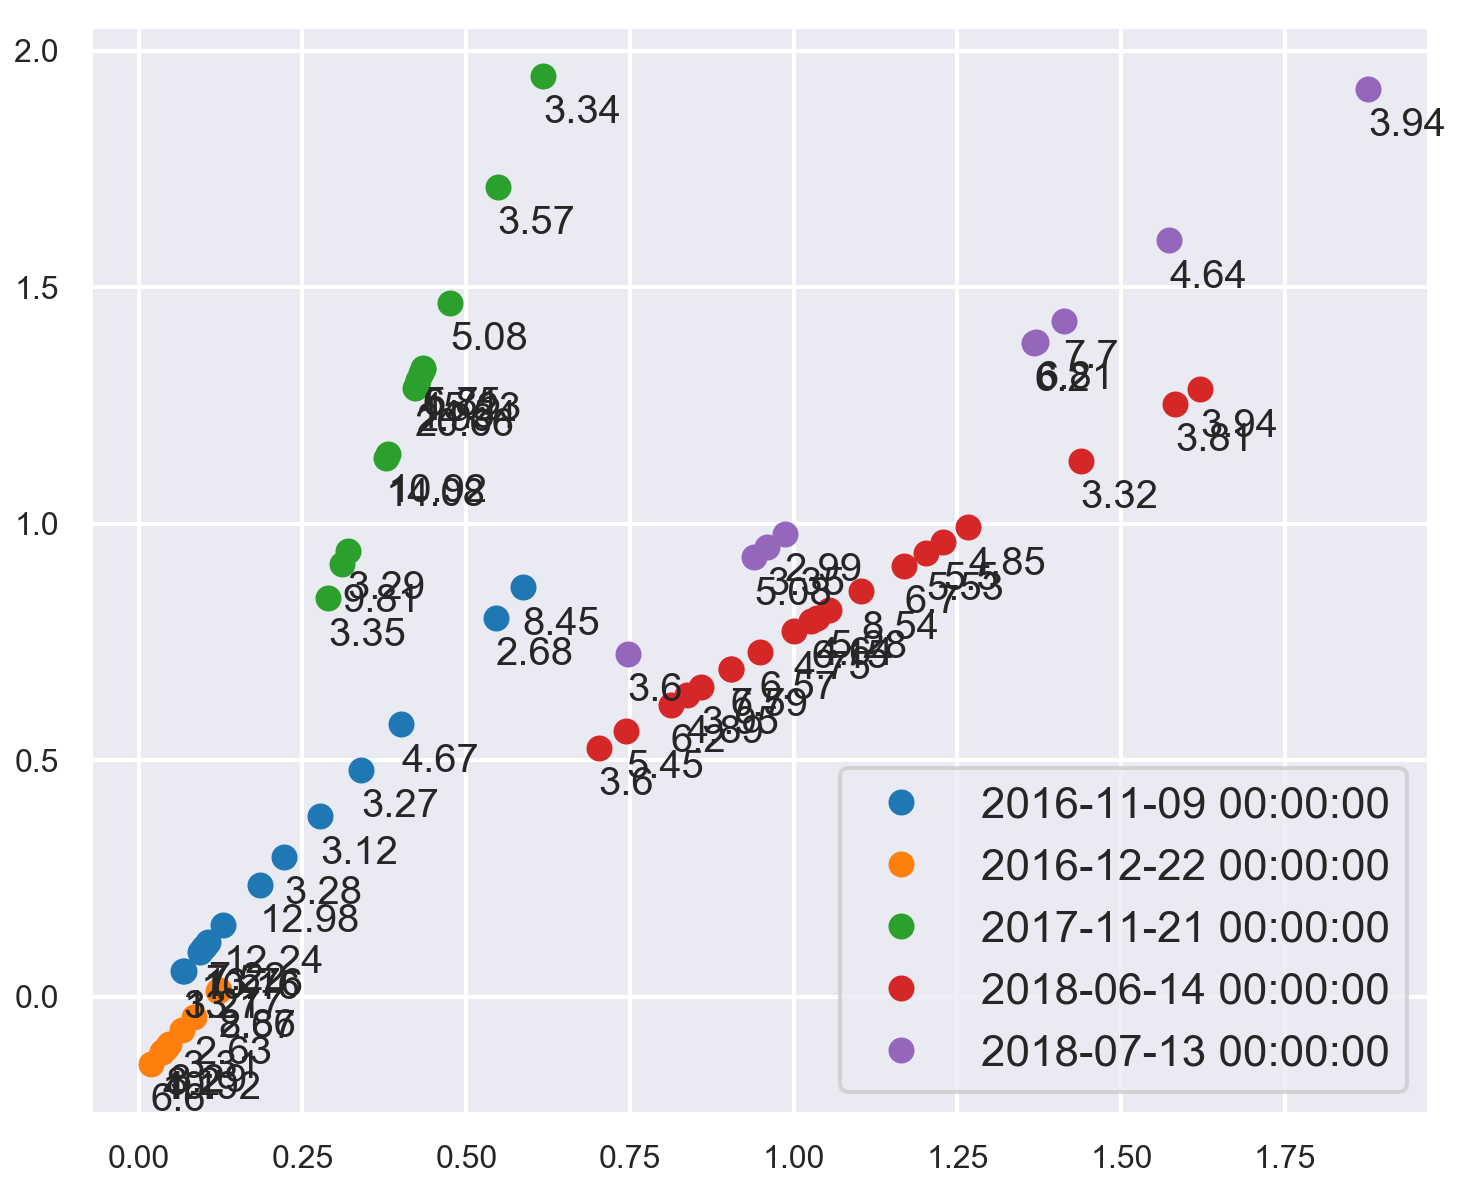

In [13]:
groups = df_remove_negative.groupby('Date')

# Plot
fig, ax = plt.subplots(figsize = (12, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Absorbance, group.Hydroxyproline, marker='o', linestyle='', ms=12, label=name)
    for k in range(len(group.Absorbance.values)):
        wod = dataBase.loc[dataBase.Rabbit == group.Rabbit_ID.values[k],'Lipid'].values[0]
        #wod = int(wod)
        ax.text(group.Absorbance.values[k], group.Hydroxyproline.values[k]-0.1, str(wod))
ax.legend()
ax.set_xlabel('Absorbance')
ax.set_ylabel('Hydroxyproline')
plt.show()

# Angle between days

In [53]:
slope_date_1 = df_remove_negative.loc[df_remove_negative.Date==date1, 'a'].iloc[0]
slope_date_3 = df_remove_negative.loc[df_remove_negative.Date==date3, 'a'].iloc[0]
slope_date_4 = df_remove_negative.loc[df_remove_negative.Date==date4, 'a'].iloc[0]
slope_date_5 = df_remove_negative.loc[df_remove_negative.Date==date5, 'a'].iloc[0]

In [86]:
tan_theta_3 = (slope_date_1 - slope_date_3)/(1+slope_date_1 * slope_date_3)
tan_theta_4 = (slope_date_1 - slope_date_4)/(1+slope_date_1 * slope_date_4)
tan_theta_5 = (slope_date_1 - slope_date_5)/(1+slope_date_1 * slope_date_5)

In [106]:
print(np.arctan(tan_theta_4)/np.pi * 180)
print(np.arctan(tan_theta_5)/np.pi * 180)
print(np.arctan(tan_theta_3)/np.pi * 180)

17.906658681375898
10.84161786249283
-16.009994703081784


# Rotation matrix

In [88]:
theta = np.arctan(tan_theta_3)
c, s = np.cos(theta), np.sin(theta)
R3 = np.array(((c,-s), (s, c)))

theta = np.arctan(tan_theta_4)
c, s = np.cos(theta), np.sin(theta)
R4 = np.array(((c,-s), (s, c)))

theta = np.arctan(tan_theta_5)
c, s = np.cos(theta), np.sin(theta)
R5 = np.array(((c,-s), (s, c)))

In [120]:
df_rotate = df_remove_negative.copy()

In [121]:
df_rotate.Absorbance = df_rotate.apply(lambda x: x.Absorbance* R4[0,0] + x.Hydroxyproline * R4[0,1] \
                                if x.Date ==date4 else x.Absorbance, axis=1)
df_rotate.Hydroxyproline = df_rotate.apply(lambda x: x.Absorbance* R4[1,0] + x.Hydroxyproline * R4[1,1] \
                                    if x.Date ==date4 else x.Hydroxyproline, axis=1)

In [122]:
df_rotate.Absorbance = df_rotate.apply(lambda x: x.Absorbance* R3[0,0] + x.Hydroxyproline * R3[0,1] \
                                if x.Date ==date3 else x.Absorbance, axis=1)
df_rotate.Hydroxyproline = df_rotate.apply(lambda x: x.Absorbance* R3[1,0] + x.Hydroxyproline * R3[1,1] \
                                    if x.Date ==date3 else x.Hydroxyproline, axis=1)

In [123]:
df_rotate.Absorbance = df_rotate.apply(lambda x:x.Absorbance* R5[0,0] + x.Hydroxyproline * R5[0,1]\
                                if x.Date == date5 else x.Absorbance, axis=1)
df_rotate.Hydroxyproline = df_rotate.apply(lambda x: x.Absorbance* R5[1,0] + x.Hydroxyproline * R5[1,1] \
                                    if x.Date ==date5 else x.Hydroxyproline, axis=1)

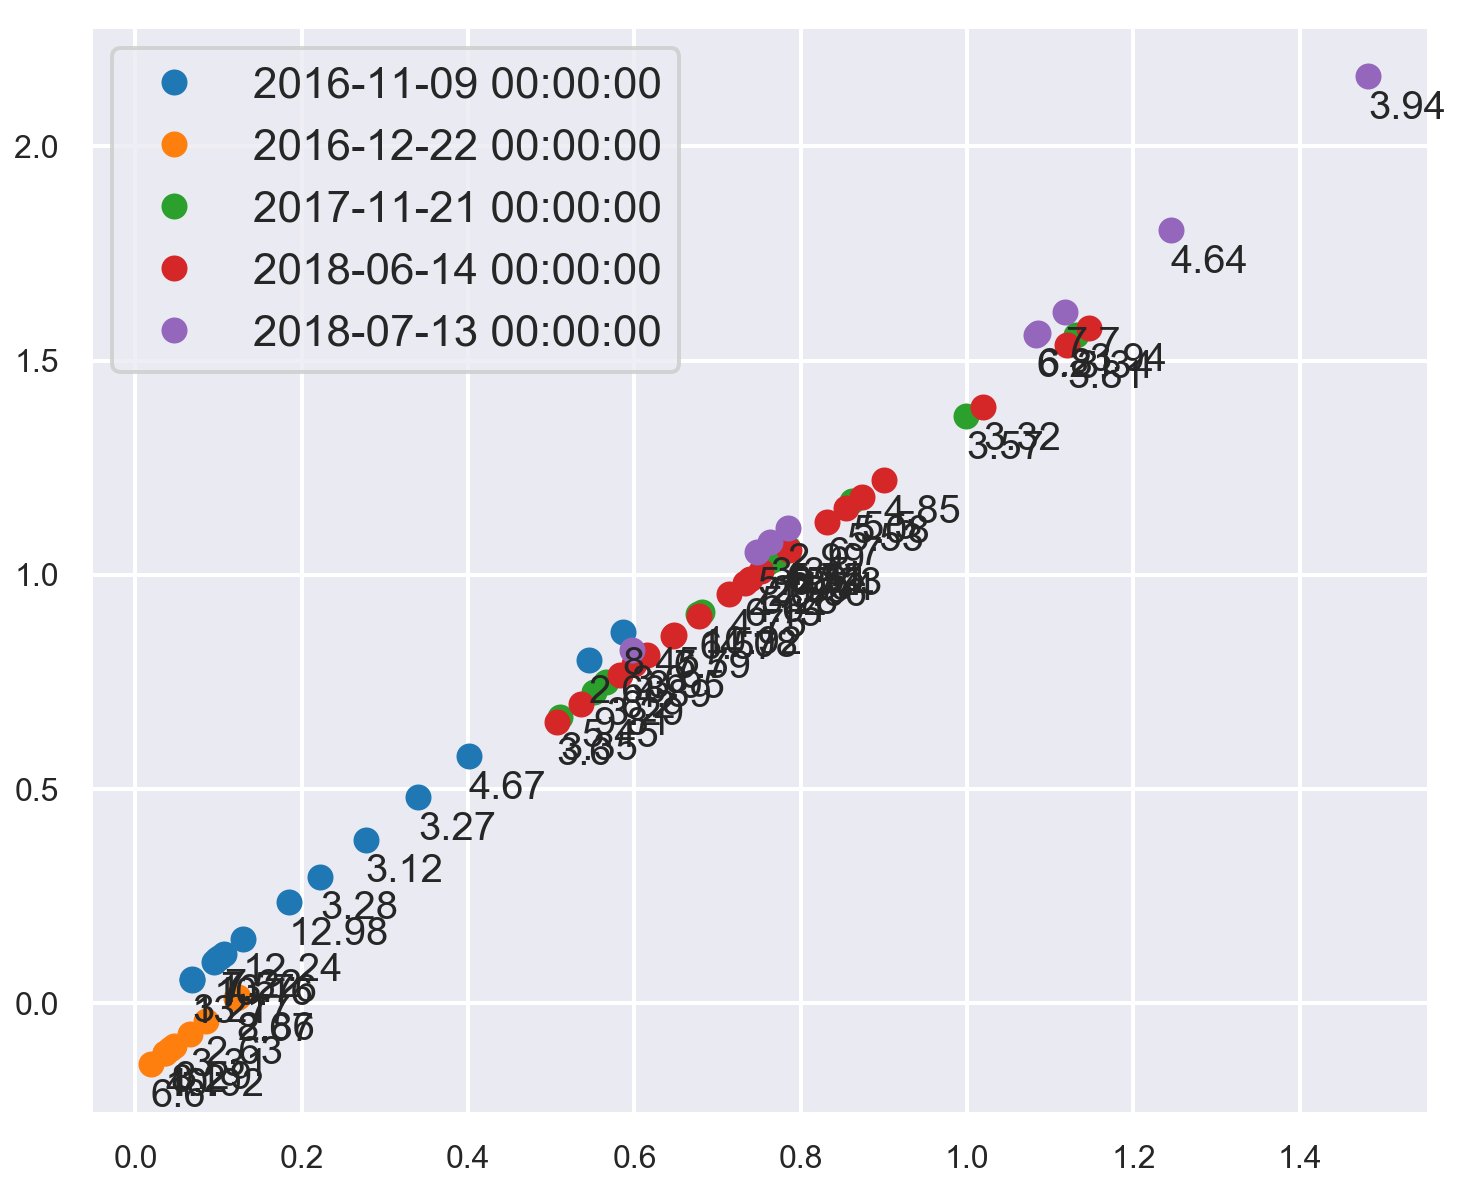

In [124]:
groups = df_rotate.groupby('Date')

# Plot
fig, ax = plt.subplots(figsize = (12, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Absorbance, group.Hydroxyproline, marker='o', linestyle='', ms=12, label=name)
    for k in range(len(group.Absorbance.values)):
        wod = dataBase.loc[dataBase.Rabbit == group.Rabbit_ID.values[k],'Lipid'].values[0]
        #wod = int(wod)
        ax.text(group.Absorbance.values[k], group.Hydroxyproline.values[k]-0.1, str(wod))
ax.legend()

plt.show()

### Injection levels

In [125]:
injection_level = pd.read_csv('injection_ml.csv', sep='\t')

In [126]:
injection_level.columns = ['ID', 'Injection']

In [127]:
injection_level.ID = injection_level.ID.str.replace('L','')

In [135]:
df_rotate['Lipid'] = df_rotate.apply(lambda row:dataBase.loc[dataBase.Rabbit == row.Rabbit_ID,\
                                                             'Lipid'].values[0], axis = 1)
df_rotate['Weeks'] = df_rotate.apply(lambda row:dataBase.loc[dataBase.Rabbit == row.Rabbit_ID,\
                                                             'Weeks on diet'].values[0], axis = 1)

In [136]:
def insert_injection(row):

    idx = injection_level.Injection[injection_level.ID.astype(str) == str(row.Rabbit_ID)]
    if (idx.size>0):
        return idx.values[0]
    else:
        return 0

In [137]:
df_rotate['Inj_ml'] = df_rotate.apply(lambda row: insert_injection(row), axis = 1)

In [139]:
df_rotate = df_rotate[df_rotate.Hydroxyproline>=0]

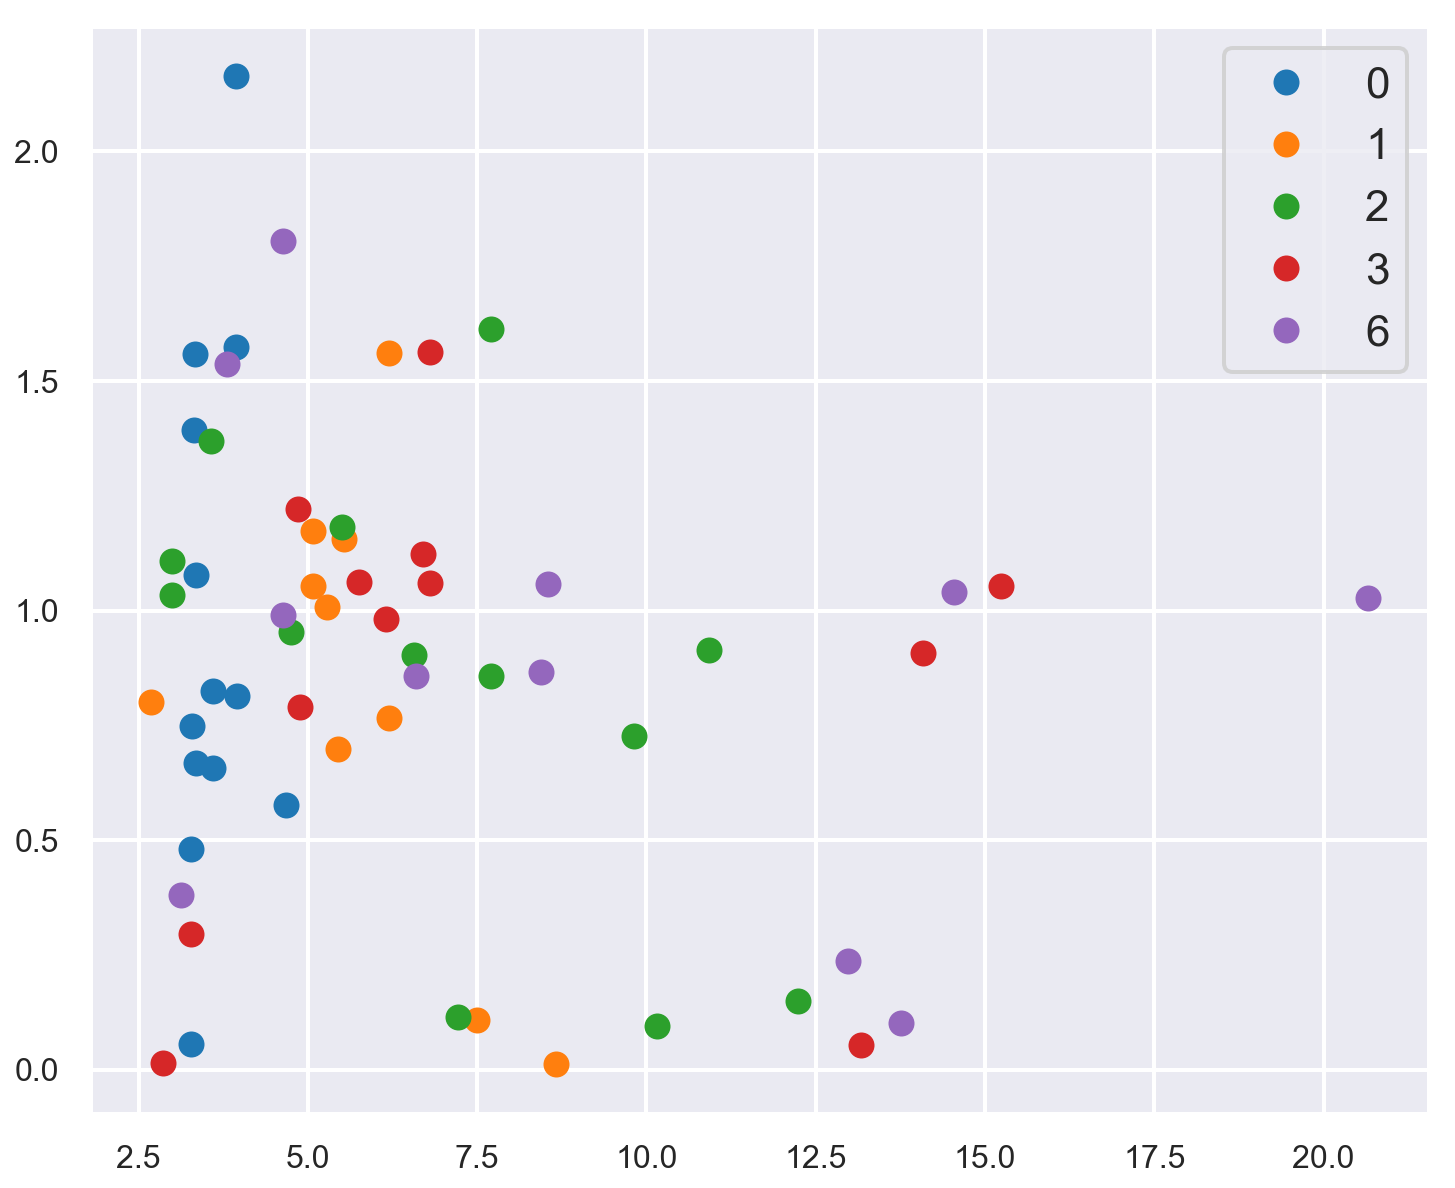

In [149]:
groups = df_rotate.groupby('Weeks')

# Plot
fig, ax = plt.subplots(figsize = (12, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Lipid, group.Hydroxyproline, marker='o', linestyle='', ms=12, label=name)
    #for k in range(len(group.Lipid.values)):
    #    wod = dataBase.loc[dataBase.Rabbit == group.Rabbit_ID.values[k],'Lipid'].values[0]
        #wod = int(wod)
    #    ax.text(group.Absorbance.values[k], group.Hydroxyproline.values[k]-0.1, str(wod))
ax.legend()

plt.show()
#sns.scatterplot(x = 'Lipid', y= 'Hydroxyproline', data = df_remove_negative)

In [143]:
final_df = df_rotate[['Rabbit_ID', 'Hydroxyproline', 'Inj_ml','Lipid', 'Weeks']]

In [144]:
temp1 = final_df[final_df.Inj_ml <5]

In [145]:
temp2 = temp1[temp1.Inj_ml > 0]

In [148]:
temp2.Hydroxyproline.corr(temp2.Inj_ml)

0.2579864342463458

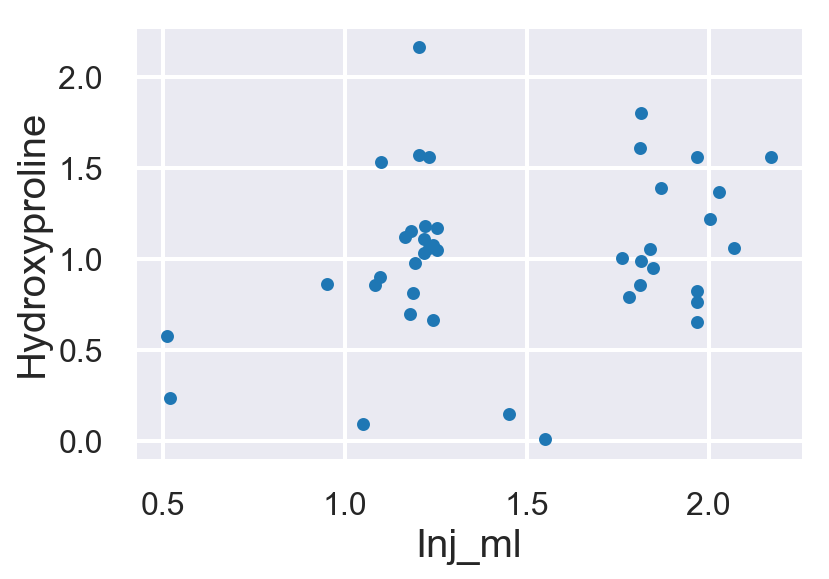

In [159]:
temp2.plot.scatter(x = 'Inj_ml', y = 'Hydroxyproline')

### Plot attenuation slope/intercept vs hydroxyproline 

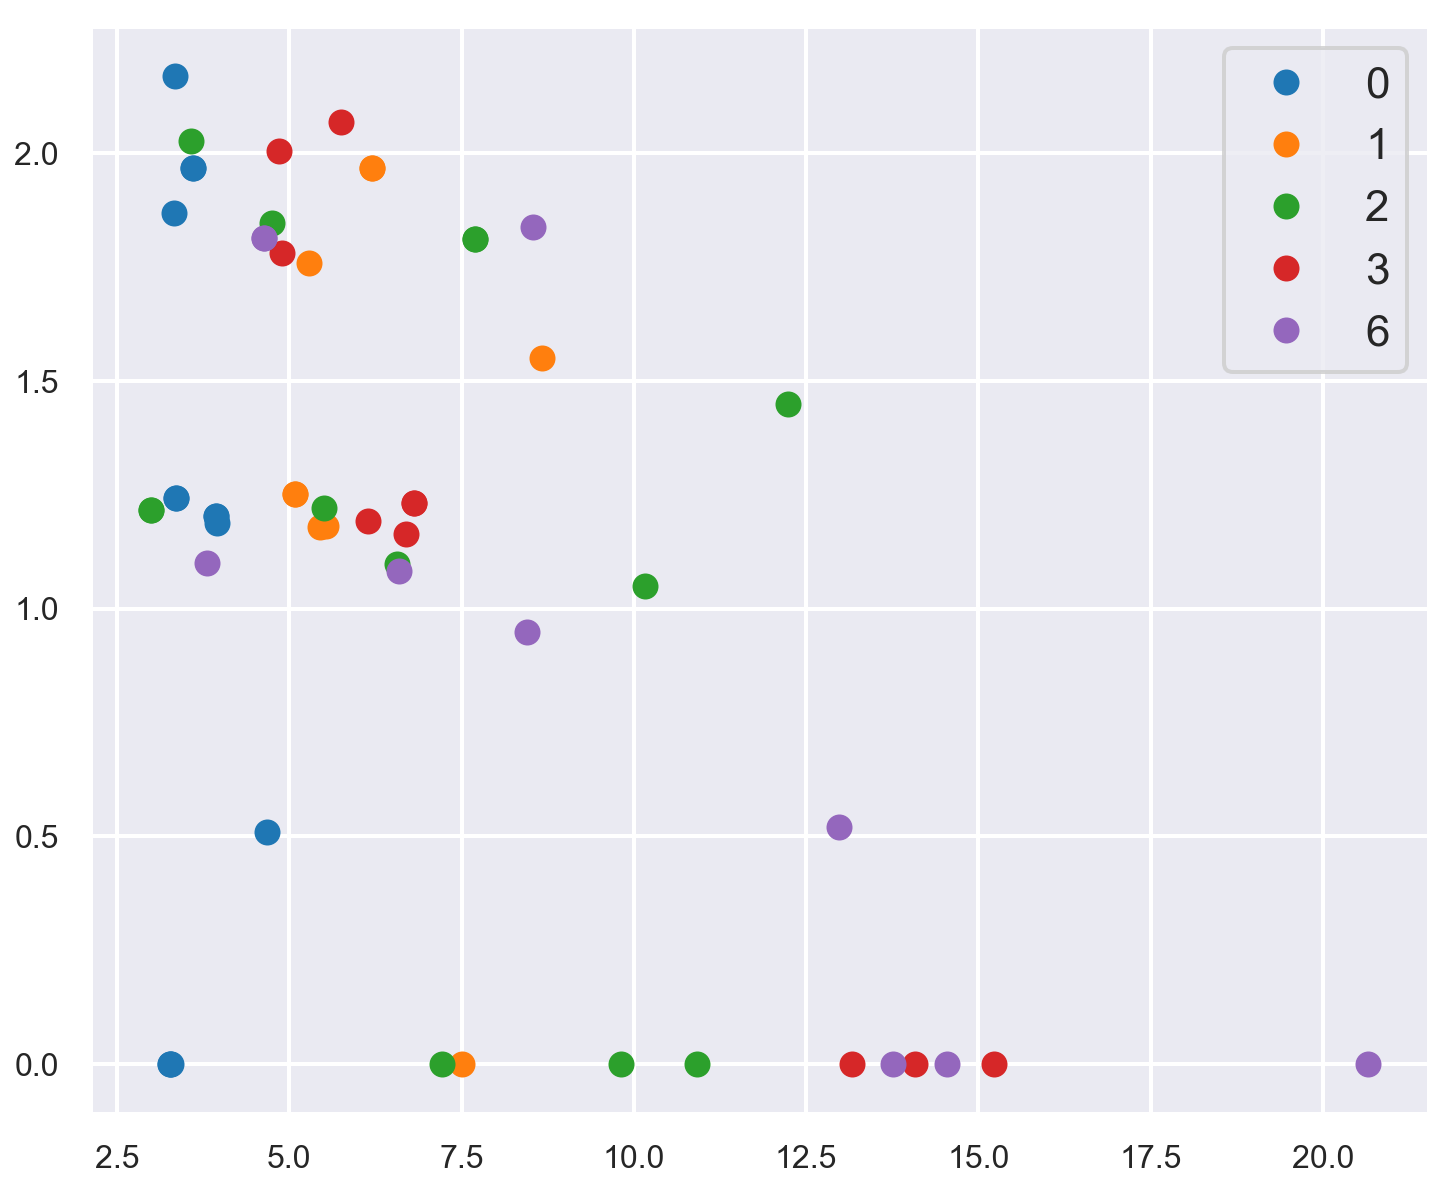

In [150]:
groups = temp1.groupby('Weeks')
fig, ax = plt.subplots(figsize = (12, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Lipid, group.Inj_ml, marker='o', linestyle='', ms=12, label=name)
ax.legend()
plt.show()

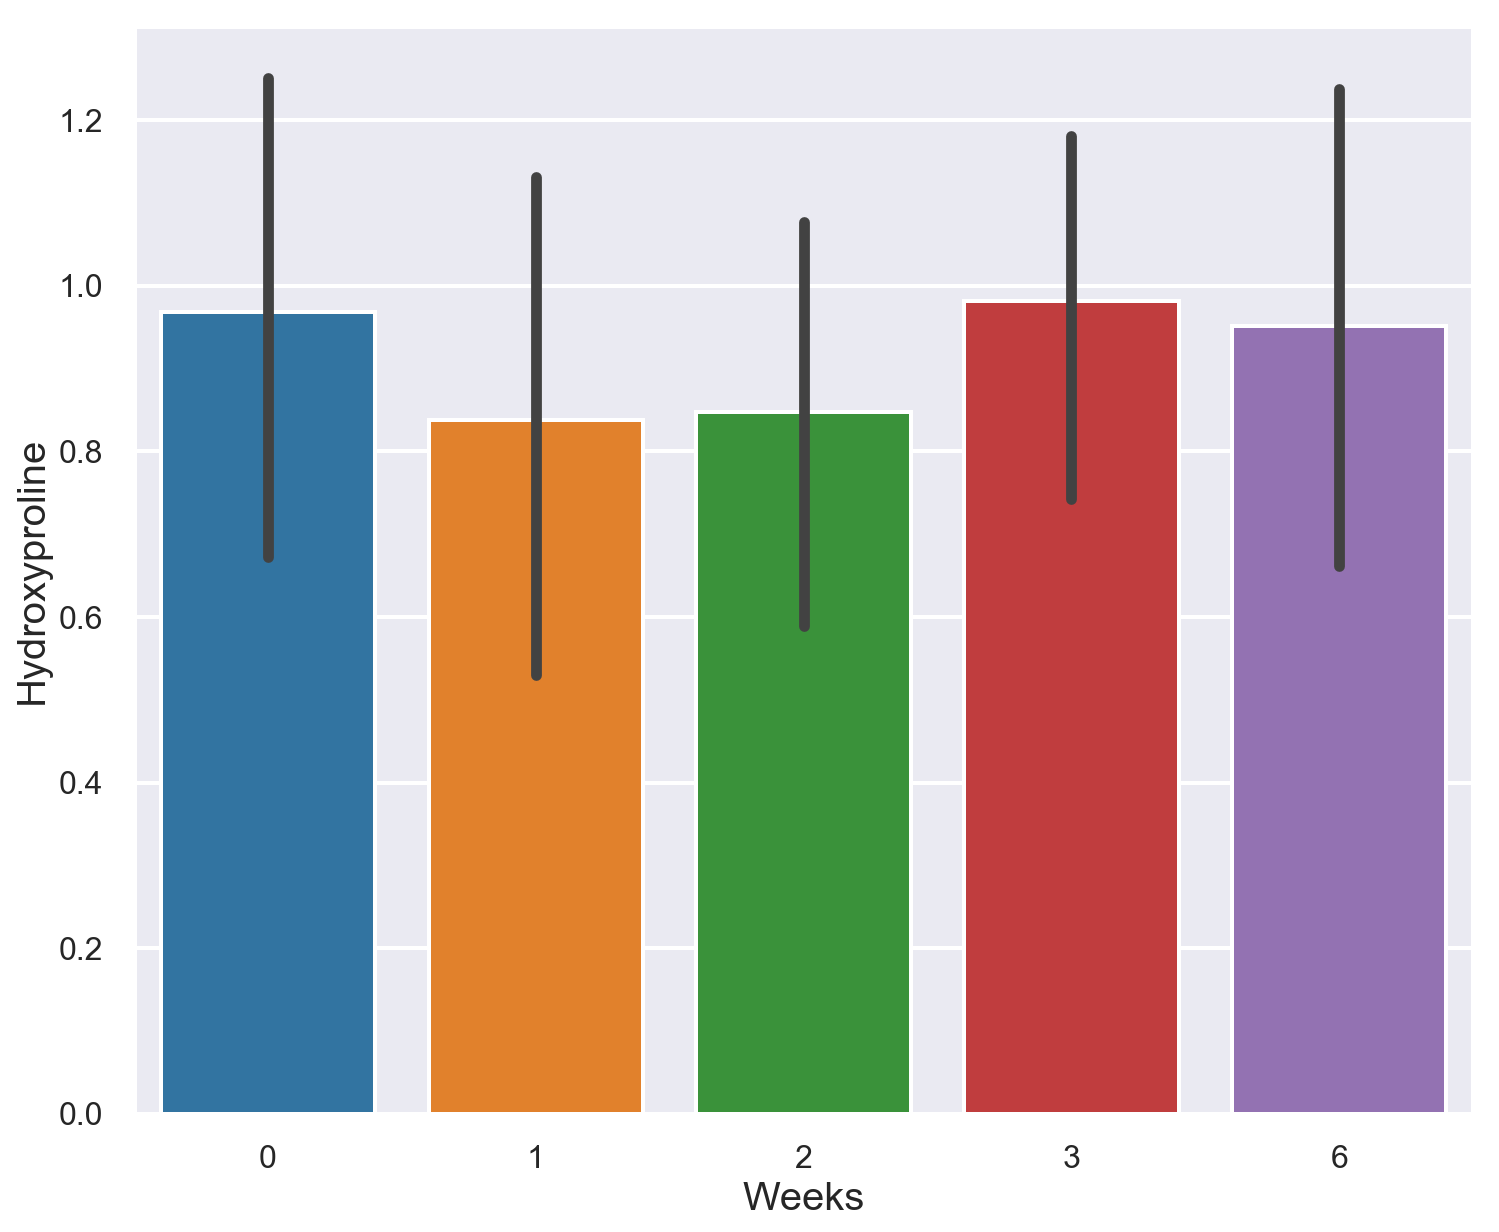

In [151]:
plt.figure(figsize = (12, 10))
sns.barplot(x = 'Weeks', y = 'Hydroxyproline', data = temp1)

In [ ]:
print(final_df.to_string())

In [157]:
temp10 = final_df.drop_duplicates(subset='Rabbit_ID')

In [158]:
writer = pd.ExcelWriter('hydro_post_process_1.xlsx')
temp10.to_excel(writer,'Sheet1')
writer.save()

In [ ]:
injection_level[injection_level.Injection>1.5]

In [ ]:
injection_level.sort_values('ID')